First, we import the necessary libraries.

In [97]:
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import os

Now, we read both training and test dataset as arrays.

In [98]:
#curr = os.getcwd()
#print(curr)
data = np.load('mnist.npz')
X_test_total, X_train_total, y_train_total, y_test_total = data['x_test'], data['x_train'], data['y_train'], data['y_test']

Let's select two digits that we will be learning to separate, for example 3 and 8.

In [99]:
num1, num2 = 3, 8

Let us form the lists of indices i such that the target of i-th object of our training data is either num1 or num2. Do the same for the test dataset.

In [100]:
train_indx = [y == num1 or y == num2 for y in y_train_total]
test_indx = [x == num1 or x == num2 for x in y_test_total]

Form new arrays consisting of the data with the target values num1 and num2 only.

In [101]:
X_train, y_train = X_train_total[train_indx], y_train_total[train_indx]
X_test, y_test = X_test_total[test_indx], y_test_total[test_indx]

Lets check the sizes of the datasets and the shape of one image.

In [102]:
print('Data shapes: ')
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)
#print(y_train[0:10])
#print(y_test[0:10])

Data shapes: 
X_train:  (11982, 28, 28)
y_train:  (11982,)
X_test:  (1984, 28, 28)
y_test:  (1984,)


In [114]:
n_train = X_train.shape[0]
n_test = X_test.shape[0]

n_train, n_test

(11982, 1984)

In [115]:
print('Shape of one item: ')
print(X_train[0].shape)

Shape of one item: 
(28, 28)


Train data are images of digits.

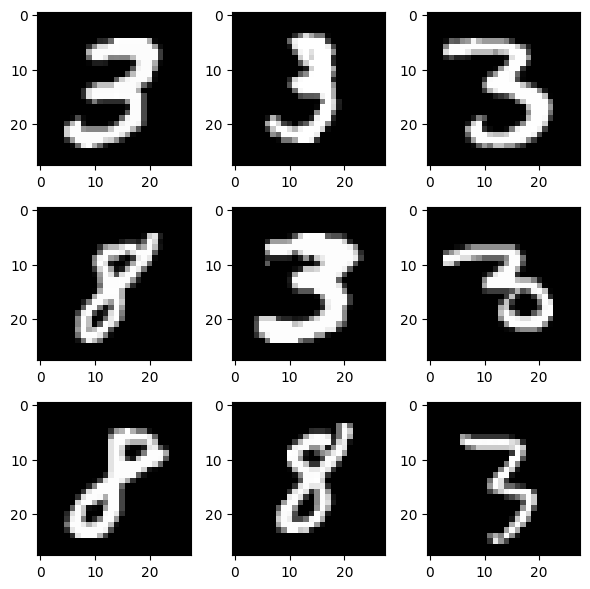

In [116]:
plt.figure(figsize=(6,6))
a, b = 3, 3
for i in range(a*b):
    plt.subplot(b, a, i+1)
    plt.imshow(X_train[i], cmap='gray')
plt.tight_layout()
plt.show()

Target values are numbers.

In [117]:
y_train[:9]

array([3, 3, 3, 8, 3, 3, 8, 8, 3], dtype=uint8)

Now our data is 3-dimensional of shape (number of images, n_pixels, n_pixels). To work with PCA and SVM we need to flatten the images by turning each of them into an array of shape (n_pixels x n_pixels, ).

In [118]:

def flatten_image(X):
    return X.flatten()

In [119]:
X_train_flat = np.array([flatten_image(img) for img in X_train])
X_test_flat = np.array([flatten_image(img) for img in X_test])
X_train_flat_unscaled = X_train_flat
X_test_flat_unscaled = X_test_flat
X_train_flat.shape, X_test_flat.shape
#print(X_train_flat[0][0:15])

((11982, 784), (1984, 784))

PCA works best when the data is scaled, so let's scale our data. Scaling replaces a collection of vectors x by the collection of the vectors $x' = (x-M)/D$, where $M$ is the mean vector of
the sample, $D$ is the vector of standard deviations of all components of the vectors, and the division is component-wise. So, the scaled collection has the same size as the original one, and each column has 0 mean and unit standard deviation.


In [120]:
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_test_flat = scaler.transform(X_test_flat)

Please write your answer on the impact of scaling below. Why does scaling help PCA? If your idea need some computer experiments for confirmation (say, training and accuracy calculations  with non-scaled data), please provide the code here as well.

In [121]:
#for unscaled data
pca = PCA(n_components=128, random_state=42)
X_train_flat_unscaled = pca.fit_transform(X_train_flat_unscaled)
X_test_flat_unscaled = pca.transform(X_test_flat_unscaled)
X_train_flat_unscaled.shape
clf = LinearSVC(random_state=42, max_iter=1000)
clf.fit(X_train_flat_unscaled, y_train)
y_pred = clf.predict(X_test_flat_unscaled)
acc = accuracy_score(y_test,y_pred)
print("Test accuracy: ", acc)



#recieved less accuracy ratio with unscaled data (0.947)
#rather then scaled (0.97)
#That happens because unclusterized data has a larger scatter and therefore
#each data object with large value deviation may be missclassified.

Test accuracy:  0.9475806451612904


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Now, we call PCA and reduce the number of components for each vector.

In [122]:
import sys
#X_train_flat_memory = sys.getsizeof(X_train_flat)
#X_test_flat_memory = sys.getsizeof(X_test_flat)
pca = PCA(n_components=128, random_state=42)
X_train_flat = pca.fit_transform(X_train_flat)

In [123]:
X_test_flat = pca.transform(X_test_flat)

In [124]:
print(X_train_flat.shape, X_test_flat.shape)
#m_ratio = sys.getsizeof(X_train_flat) / X_train_flat_memory
#print('Memory ratio is:', m_ratio)

(11982, 128) (1984, 128)


The memory compression will be 128/784 as we reduce number of columns form 784 to 128 and the number of rows remain the same. Ive tried also calculate memory ratio with getsizeof() method but it returned very small number.

Now, we use SVM with linear kernel to separate the two classes.

In [125]:
%%time
clf = LinearSVC(random_state=42, max_iter=1000)
clf.fit(X_train_flat, y_train)
#X_train_flat.shape, y_train.shape

CPU times: user 5.5 s, sys: 14.6 ms, total: 5.51 s
Wall time: 5.87 s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=42)

Now, let us make the predictions and calculate the accuracy, that is, the ratio of the true predictions to the test sample size. 

$$accuracy(y\_true, y\_pred) = \frac{1}{n}\sum_{i=1}^n [y\_true_i=y\_pred_i],$$ where $[a=b]=1$, if $a=b$, and $0$ otherwise.

In [127]:
y_pred = clf.predict(X_test_flat)
#print(y_pred[0:10])
#print(y_train[0:10])
#print(y_test[0:10])
#print(y_train.shape, y_test.shape)
acc = accuracy_score(y_test,y_pred)
print("Test accuracy: ", acc)

Test accuracy:  0.9667338709677419


Lets try this now on my hand-written numbers:

In [163]:
from scipy import misc
from PIL import Image

In [165]:
image = Image.open('/content/test9.jpg').convert('L')
new_image = image.resize((28, 28))
custom = np.array(new_image)
custom.shape

(28, 28)

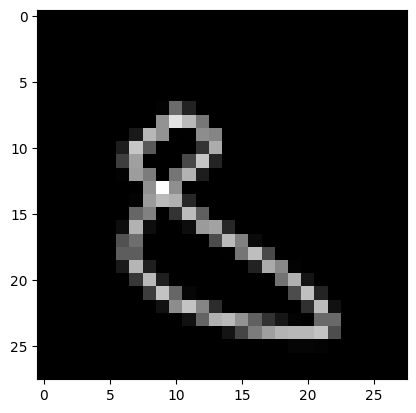

In [166]:
plt.imshow(custom, cmap='gray')
plt.show()

Now lets re-shape the image and make a prediction:

In [167]:
custom = flatten_image(custom).reshape(1, -1)
custom = scaler.transform(custom)
custom = pca.transform(custom)
custom.shape

(1, 128)

In [168]:
clf.predict(custom)

array([8], dtype=uint8)

Now let's try another approach. For each digit, we create a new matrix $A$ whose columns are flattened images of this digit. The first several (say, 10) columns of the matrix $U$ from SVD decomposition of $A$ represent a collection of "typical" images of this digit. With unrecognized flatten image given, among average typical flattened images we find the closets one. Its target value is considered as a prediction for the target of the unrecognized image.

SVD of a matrix $A$ is a decomposition:
$A = U \Sigma V^T,$ where $U$ and $V$ are orthogonal matrices. In this method we will be utilizing some properties of SVD.

In [104]:
def getSingularVectorsLeft(matrix, number=10): # let's take first 10 numbers
    # return first _number_ columns of U from SVD of _matrix_
    U,Ep,V_tr = np.linalg.svd(matrix)
    return U[:,:number]

In [105]:
def getSingularImage(X_train, y_train, number):
    # find images whose target is _number_
    index_list = [i == number for i in y_train]
    select_images = X_train[index_list]
    count = 0
    for image in select_images:
      if count == 0:
        A = np.reshape(image, (-1, 1))
        count += 1
      else:
        # iteratively append new column to form matrix A
        A = np.append(A, np.reshape(image, (-1, 1)), axis = 1)
        count += 1
    # left_basis = # get left singular vectors
    left_basis = getSingularVectorsLeft(A)
    return left_basis

Trying it first on "0".

In [106]:
left_basis = getSingularImage(X_train_total, y_train_total, 5)
print(left_basis.shape)
assert left_basis.shape, (784, 10)


(784, 10)


Lets plot first 9 singular images of the digit 0 taking columns of matrix U and reshaping them back into images 28x28.

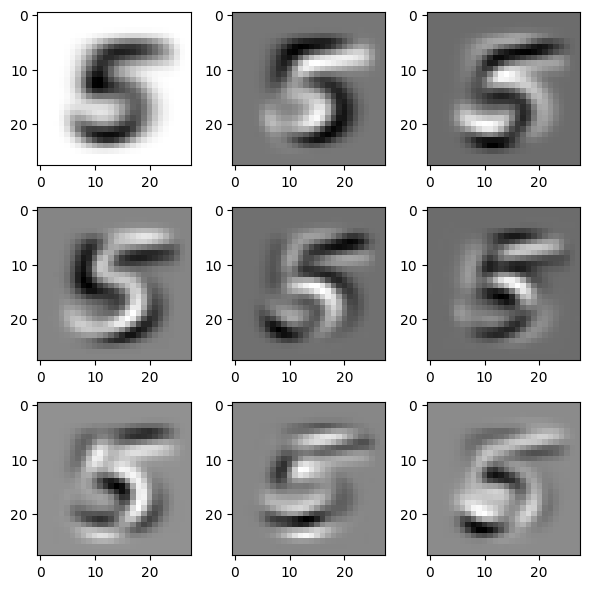

In [77]:
#singular images
plt.figure(figsize=(6,6))
a, b = 3, 3
for i in range(a*b):
    plt.subplot(b, a, i+1)
    img = np.reshape(left_basis[:,i:i+1], (28,28)) # ith element of left basis reshaped back to 28x28
    plt.imshow(img, cmap='gray')

plt.tight_layout()
plt.show()

Each column of Uk represents a matrix of a picture reshaped to column-vector. Each column-vector contains numbers and each of them represents the colour of corresponding pixel of an image.

Now let's move on and obtain singular images for all numbers. 

In [107]:
number_basis_matrices = [getSingularImage(X_train_total, y_train_total, k) for k in range(10)]# use getSingularImage funciton to get matrices for all numbers
number_basis_matrices = np.array(number_basis_matrices)
#print(number_basis_matrices.shape)

Lets plot the first singular image of each digit, similarly to the previous step.

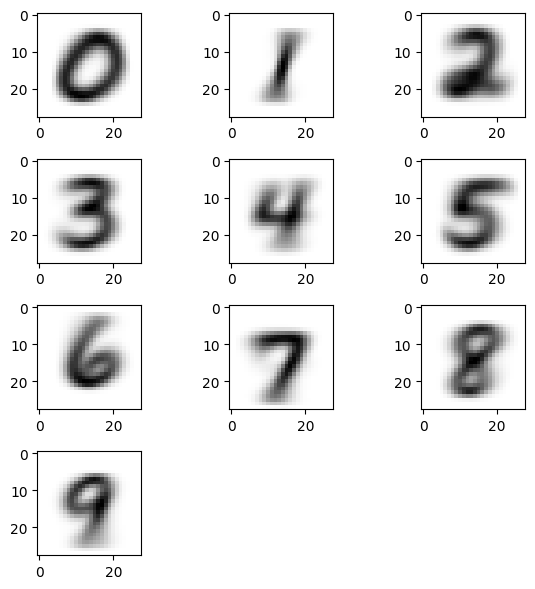

In [108]:
plt.figure(figsize=(6,6))
a, b = 3, 4
for i in range(10):
    plt.subplot(b, a, i+1)
    img = np.reshape(number_basis_matrices[i][:,0:1], (28,28)) # first column of U_k in number_basis_matrices[i] reshaped into 28x28 image
    plt.imshow(img, cmap='gray')

plt.tight_layout()
plt.show()

In [109]:
dim = number_basis_matrices[0].shape[0]
#print(dim)

Now we calculate the new projection matrix for each $U_k$ to apply later in testing:
$pr = (I - U_k \cdot U_{k}^{T})$. This operation might also take some time to finish.

In [110]:
numeric_values = []# create an array of pr for each number
for u in number_basis_matrices:
  U_Ut = np.matmul(u, u.transpose())
  identity_row_num = int((U_Ut.shape)[0])
  pr = np.identity(identity_row_num) - U_Ut
  numeric_values.append(pr)
numeric_values = np.array(numeric_values)
#print(numeric_values.shape)

Now lets implement function utilizing matrices to predict labels for unknown images.

In [111]:
def find_closest(test_value, numeric_values):
    stacked_test = test_value.reshape(-1, 1)
    distances = [np.linalg.norm(np.matmul(matrix, stacked_test)) for matrix in numeric_values]
    target = np.argmin(distances)
    return target

In [112]:
y_pred = [find_closest(i,numeric_values) for i in X_test]

In [113]:
acc = accuracy_score(y_test, y_pred)
print(y_pred[0:10])
print(y_test[0:10])
print(acc)

[3, 3, 3, 3, 3, 8, 3, 3, 3, 8]
[3 3 3 3 3 8 3 3 3 8]
0.9304435483870968
